In [ ]:
!pip install -U torch transformers trl datasets umap-learn matplotlib seaborn pip  --q

In [7]:
!pip install git+https://github.com/Profluent-AI/E1.git --quiet


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.24.1 requires torch==2.9.1, but you have torch 2.8.0 which is incompatible.
torchaudio 2.9.0 requires torch==2.9.0, but you have torch 2.8.0 which is incompatible.


In [47]:
import pandas as pd
import torch 
import E1.dist as dist
from E1.modeling import E1ForMaskedLM
from E1.predictor import E1Predictor

data = pd.read_csv("../inputs/predictive-pet-zero-shot-test-2025.csv")
data.head()


model_name = "Profluent-Bio/E1-150m"

model = E1ForMaskedLM.from_pretrained(model_name, dtype=torch.float).to(dist.get_device()).eval()
predictor = E1Predictor(
    model=model,
    max_batch_tokens=16384,  # Change to 4096 on Colab T4 GPU
    fields_to_save=["token_embeddings", "mean_token_embeddings"],
)

sequence_embeddings = []

for prediction in predictor.predict(
    sequences=data["sequence"].to_list(), sequence_ids=data.index.to_list(), context_seqs=None
):
    id = prediction["id"]
    token_embeddings = prediction["token_embeddings"]  
    mean_token_embeddings = prediction["mean_token_embeddings"] 
    sequence_embeddings.append({"id": id, "mean_sequence_embedding": mean_token_embeddings.cpu().numpy(), "token_sequence_embedding" : token_embeddings.cpu().numpy()})

model_name = model_name.replace("/","_")
df = pd.DataFrame(sequence_embeddings)
df.to_pickle(f'../embeddings/sequence_embeddings{model_name}.pkl')
df_loaded = pd.read_pickle(f'../embeddings/sequence_embeddings{model_name}.pkl')
df_loaded.head()

Predicting batches: 100%|██████████| 80/80 [00:34<00:00,  2.33it/s]


,id,mean_sequence_embedding,token_sequence_embedding
0,4776,"[-0.0018524003, 0.014027663, 0.013941843, -0.0...","[[-0.057861328, 0.106933594, 0.19335938, -0.19..."
1,4691,"[0.025277482, -0.017208435, 0.01673907, -0.036...","[[-0.0035552979, 0.09472656, 0.063964844, -0.0..."
2,4982,"[0.013821455, 0.039744064, 0.03631506, -0.0171...","[[0.014282227, 0.05102539, 0.18359375, -0.1386..."
3,4985,"[-0.00737367, -0.0056649297, 0.021186862, -0.0...","[[-0.13867188, 0.063964844, 0.12695312, -0.090..."
4,4709,"[0.040555436, 0.033567708, 0.020160522, -0.013...","[[0.084472656, -0.018798828, 0.03564453, 0.013..."


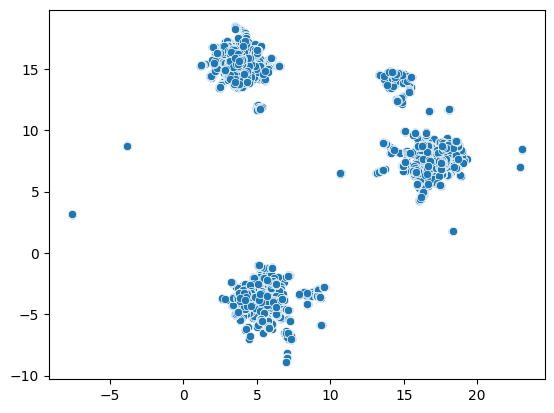

In [5]:
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

model_name = "Profluent-Bio_E1-150m"

df_loaded = pd.read_pickle(f'../embeddings/sequence_embeddings{model_name}.pkl')

sequence_embeddings_array = np.array(df_loaded["mean_sequence_embedding"].to_list())

umap = UMAP(n_components=2)
sequence_embeddings_2d = umap.fit_transform(sequence_embeddings_array)

sns.scatterplot(x=sequence_embeddings_2d[:, 0], y=sequence_embeddings_2d[:, 1])
plt.show()

=== Sequence Length Summary ===
Total sequences: 4988
Min length: 183
Max length: 266
Mean length: 257.57
Median length: 259

=== Detailed Statistics ===
count    4988.000000
mean      257.567362
std         3.559581
min       183.000000
25%       257.000000
50%       259.000000
75%       259.000000
max       266.000000
dtype: float64


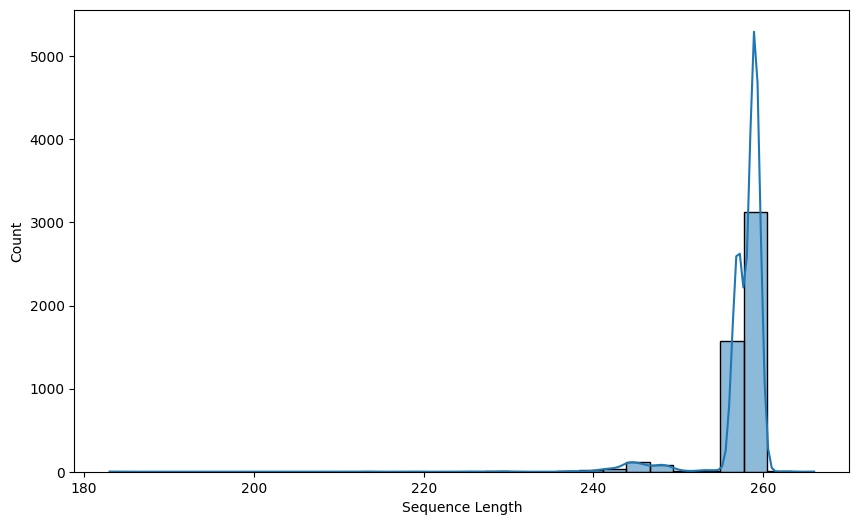

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv("../inputs/predictive-pet-zero-shot-test-2025.csv")
data.head()

lengths = [len(x) for x in data["sequence"]]

# Print summary statistics
print("=== Sequence Length Summary ===")
print(f"Total sequences: {len(lengths)}")
print(f"Min length: {min(lengths)}")
print(f"Max length: {max(lengths)}")
print(f"Mean length: {sum(lengths)/len(lengths):.2f}")
print(f"Median length: {sorted(lengths)[len(lengths)//2]}")

# Or using pandas for more detailed stats
lengths_series = pd.Series(lengths)
print("\n=== Detailed Statistics ===")
print(lengths_series.describe())

# Visualization
plt.figure(figsize=(10, 6))
sns.histplot(lengths, bins=30, kde=True)
plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.show()

In [7]:
fasta = [f">{idx}\n{seq}\n" for idx,seq in zip(data.index.to_list(),data["sequence"].to_list())]

with open("../inputs/predictive-pet-zero-shot-test-2025.fasta","w") as f:
    f.write("".join(fasta))